In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env

## Acquire 

#### Acquire the data by storing the contents of 'saas.csv' into a Pandas dataframe.

In [2]:
df = pd.read_csv('saas.csv')

In [3]:
# Check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


## Takeaways
* I will have to convert 'Month_Invoiced' to a datetime datatype and set it as the index.


In [4]:
# Change 'Month_Invoiced' column into a datetime datatype.
df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)

In [5]:
# Set 'Month_Invoiced' as the index for the dataframe.
df = df.set_index('Month_Invoiced').sort_index()

In [6]:
df

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...
2017-12-31,1029395,5790453,0.0,0.0
2017-12-31,1029396,5790454,0.0,0.0
2017-12-31,1029397,5790455,3.0,15.0


In [7]:
len(df.Customer_Id.value_counts())

29400

## Takeaways
* There are 29400 different customers in this dataframe
* There are some invoices where there is a new 'Customer_Id' value, but both 'Subscription_Type' and 'Amount' have 0.0 values. I wonder what this means.
* These capital letters are annoying to deal with. I will change the names of the columns.

I will look at individual customers to see if I can find the reason for these 0.0 values. I'm guessing that the first month or two may be free for the new customer.

In [8]:
df.rename(columns={'Customer_Id':'customer','Invoice_Id':'invoice','Subscription_Type':'subscription','Amount':'amount'}, inplace=True)

In [9]:
df[df['customer'] == 1000000]

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-02-28,1000000,5020000,0.0,0.0
2014-03-31,1000000,5039800,0.0,0.0
2014-04-30,1000000,5059399,0.0,0.0
2014-05-31,1000000,5078812,0.0,0.0
2014-06-30,1000000,5098033,0.0,0.0
2014-07-31,1000000,5117071,0.0,0.0
2014-08-31,1000000,5135922,0.0,0.0
2014-09-30,1000000,5154594,0.0,0.0


## Takeaways
* This customer got their first year free?

Let's look at a few more..

In [10]:
df[df['customer'] == 1000001]

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2014-01-31,1000001,5000001,2.0,10.0
2014-02-28,1000001,5020001,2.0,10.0
2014-03-31,1000001,5039801,2.0,10.0
2014-04-30,1000001,5059400,2.0,10.0
2014-05-31,1000001,5078813,2.0,10.0
2014-06-30,1000001,5098034,2.0,10.0
2014-07-31,1000001,5117072,2.0,10.0
2014-08-31,1000001,5135923,2.0,10.0
2014-09-30,1000001,5154595,2.0,10.0


In [11]:
df[df['customer'] == 1000002]

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2014-01-31,1000002,5000002,0.0,0.0
2014-02-28,1000002,5020002,1.0,5.0


In [12]:
df[df['customer'] == 1000003]

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2014-01-31,1000003,5000003,0.0,0.0
2014-02-28,1000003,5020003,0.0,0.0
2014-03-31,1000003,5039802,0.0,0.0
2014-04-30,1000003,5059401,0.0,0.0
2014-05-31,1000003,5078814,0.0,0.0
2014-06-30,1000003,5098035,0.0,0.0
2014-07-31,1000003,5117073,0.0,0.0
2014-08-31,1000003,5135924,0.0,0.0
2014-09-30,1000003,5154596,0.0,0.0


In [13]:
df[df['customer'] == 1000004]

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2014-01-31,1000004,5000004,1.0,5.0
2014-02-28,1000004,5020004,1.0,5.0
2014-03-31,1000004,5039803,1.0,5.0
2014-04-30,1000004,5059402,1.0,5.0
2014-05-31,1000004,5078815,1.0,5.0
2014-06-30,1000004,5098036,1.0,5.0
2014-07-31,1000004,5117074,1.0,5.0
2014-08-31,1000004,5135925,1.0,5.0
2014-09-30,1000004,5154597,1.0,5.0


In [14]:
df[df['customer'] == 1000006]

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2014-01-31,1000006,5000006,0.0,0.0
2014-02-28,1000006,5020006,0.0,0.0
2014-03-31,1000006,5039805,0.0,0.0
2014-04-30,1000006,5059404,0.0,0.0
2014-05-31,1000006,5078817,0.0,0.0
2014-06-30,1000006,5098038,0.0,0.0
2014-07-31,1000006,5117076,0.0,0.0
2014-08-31,1000006,5135927,0.0,0.0
2014-09-30,1000006,5154599,0.0,0.0


## Takeaways
* There are some customers who have 1 year of no charges, there are some customers who have 2 years of no charges, there are some customers that have multiplie invoices with no charges, then invoices stop suddenly, and then there are some customers where their charges start immediately. 

I'm not sure what the situation is here without more information.


# For this exercise we will set the 'amount' as the target variable. We will then create a model that will be able to predict future revenue.

In [15]:
target = df.amount

### Let's plot the target variable over time.
We will first aggregate the amount by the date using sum(). We will then do a quick plot of this aggregated data.

<AxesSubplot:xlabel='Month_Invoiced'>

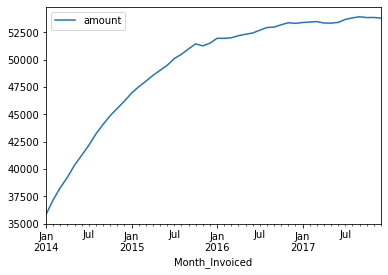

In [16]:
by_date = df.groupby(['Month_Invoiced']).amount.sum().reset_index()
by_date.plot(x='Month_Invoiced', y='amount')

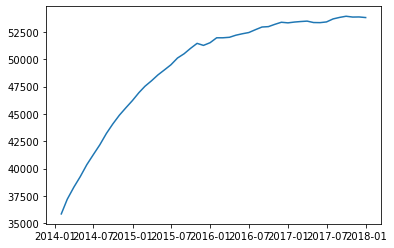

In [22]:
pd.DataFrame(df.resample('m').amount.sum())
plt.plot(df.resample('m').amount.sum())

## Takeaways
* The slope of the graph represents Δx/Δt where Δx is the change in amount and Δt is the change in time. Therefore, it is the rate of change of amount(money) with respect to time.
* The slope of the graph is reaching zero as time passes. Which means growth is slowing and the amount will eventually reach a constant value.


## We'll split the data and use four different methods to forecast the target variable.

In [24]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [25]:
# Check to make sure the last observation of train is before the first observation of validate.
pd.concat([train.tail(1), validate.head(1)])

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2015-10-31,1019181,5395228,0.0,0.0
2015-10-31,1019182,5395229,0.0,0.0


In [26]:
# Check to make sure the last observation of validate is before the first observation of test.
pd.concat([validate.tail(1), test.head(1)])

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2017-01-31,1026538,5632365,0.0,0.0
2017-01-31,1026539,5632366,0.0,0.0


### Let's plot our data first, viewing where the data is split into train and test.

In [27]:
train

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...
2015-10-31,1019173,5395224,0.0,0.0
2015-10-31,1019175,5395225,0.0,0.0
2015-10-31,1019177,5395226,1.0,5.0


<AxesSubplot:xlabel='Month_Invoiced'>

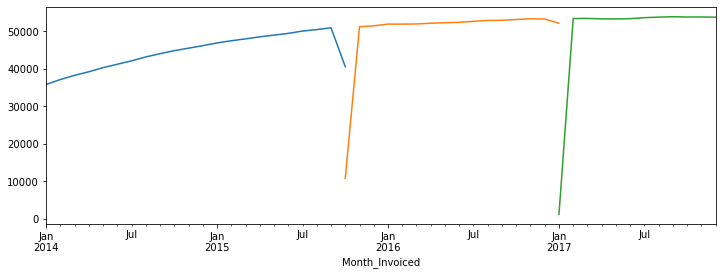

In [28]:
plt.figure(figsize=(12,4))
train.amount.resample('M').sum().plot(label='Montly')
validate.amount.resample('M').sum().plot()
test.amount.resample('M').sum().plot()

## Takeaways
* After splitting the data using percentages the graph became a little distorted.
* I'm sure the reason is because I'm splitting months, so I'm not getting the full sum at that particular moment in time. 
* I'll try to move the cut points manually to make sure I'm capturing a whole month at those split points.

In [29]:
# Check the last few dates of train.
train.tail(5)

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2015-10-31,1019173,5395224,0.0,0.0
2015-10-31,1019175,5395225,0.0,0.0
2015-10-31,1019177,5395226,1.0,5.0
2015-10-31,1019180,5395227,0.0,0.0
2015-10-31,1019181,5395228,0.0,0.0


In [30]:
# Check the first few dates of validate and see where the data is being split.
validate.head(5)

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2015-10-31,1019182,5395229,0.0,0.0
2015-10-31,1019183,5395230,0.0,0.0
2015-10-31,1019185,5395231,1.0,5.0
2015-10-31,1019186,5395232,0.0,0.0
2015-10-31,1019187,5395233,0.0,0.0


In [43]:
# Check the last few dates of validate and see where the data is being split.
validate.tail(5)

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2015-11-30,1024395,5415621,0.0,0.0
2015-11-30,1024396,5415622,1.0,5.0
2015-11-30,1024397,5415623,0.0,0.0
2015-11-30,1024398,5415624,0.0,0.0
2015-11-30,1024399,5415625,0.0,0.0


In [44]:
# Check the first few dates of the test dataset to see where the data is being split.
test.head(5)

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2017-01-31,1026539,5632366,0.0,0.0
2017-01-31,1026540,5632367,1.0,5.0
2017-01-31,1026541,5632368,0.0,0.0
2017-01-31,1026542,5632369,4.0,20.0
2017-01-31,1026543,5632370,0.0,0.0


## Takeaways
* Yup. My initial hypothesis was correct. The data is being split within a month instead of the end of the month which is causing the graph to look funky. I will manually shift the beginning and ending points of each dataset to make sure they are ending/beginning at the end/beginning of a month. Hopefully this will smooth out the graph so I have data I can work with.

In [123]:
# Create the train dataset
train = df[:'2015-12-31']
# Create a new dataframe that will be the original dataframe resampled by month.
train_month = pd.DataFrame(train.amount.resample('M').mean())

In [124]:
train_month

,amount
Month_Invoiced,
2014-01-31,1.792500
2014-02-28,1.878283
2014-03-31,1.953926
2014-04-30,2.022099
2014-05-31,2.099527
2014-06-30,2.166982
2014-07-31,2.237017
2014-08-31,2.314160
2014-09-30,2.383205


In [125]:
# Create the validate dataset.
validate = df['2016-01':'2016-12']
# Create a dataframe that resamples validate by month.
validate_month = pd.DataFrame(validate.amount.resample('M').mean())

In [127]:
validate_month

,amount
Month_Invoiced,
2016-01-31,3.218622
2016-02-29,3.243336
2016-03-31,3.271469
2016-04-30,3.307980
2016-05-31,3.335990
2016-06-30,3.367478
2016-07-31,3.408473
2016-08-31,3.447737
2016-09-30,3.476050


In [126]:
# Create the test dataset.
test = df['2017':]
# Create a dataframe that resamples the test dataset by month.
test_month = pd.DataFrame(test.amount.resample('M').mean())

In [128]:
test_month

,amount
Month_Invoiced,
2017-01-31,3.598046
2017-02-28,3.625263
2017-03-31,3.646778
2017-04-30,3.660126
2017-05-31,3.684974
2017-06-30,3.708681
2017-07-31,3.750699
2017-08-31,3.787740
2017-09-30,3.816078


<AxesSubplot:xlabel='Month_Invoiced'>

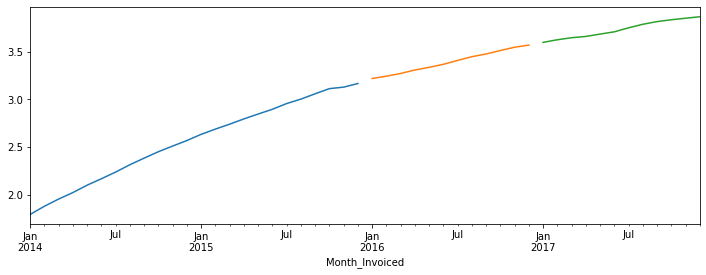

In [103]:
plt.figure(figsize=(12,4))
train.amount.resample('M').mean().plot()
validate.amount.resample('M').mean().plot()
test.amount.resample('M').mean().plot()

<AxesSubplot:xlabel='Month_Invoiced'>

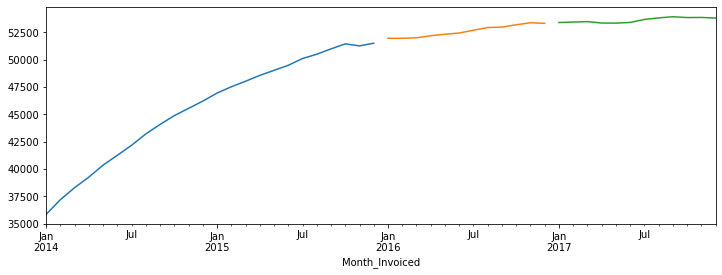

In [105]:
plt.figure(figsize=(12,4))
train.amount.resample('M').sum().plot()
validate.amount.resample('M').sum().plot()
test.amount.resample('M').sum().plot()

In [62]:
train['2015-08':'2015-10'].resample('m').sum()

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2015-08-31,17023990262,90099263710,10099.0,50495.0
2015-09-30,16878325806,89596188954,10197.0,50985.0
2015-10-31,12639036259,67464502911,8121.0,40605.0


## Takeaways
* The graph has been fixed, but there are gaps where one dataset ends and the next begins. I believe this is due to each month beginning and ending on the last day of the month.
* I don't think there is anything around this, but I think modeling can still work. Let's try.

### Autocorrelation Plot

Let's run an autocorrelation plot to see if there are any useful lag values to use.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

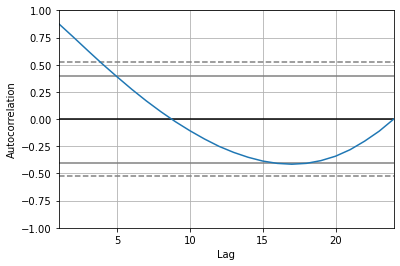

In [95]:
pd.plotting.autocorrelation_plot(train.amount.resample('m').mean())

### Forecast, plot and evaluate using each of these four parametric based methods:
1) Simple Average

2) Moving Average

3) Holt's Linear Trend Model

4) Based on previous year/month/etc.

# 1) Simple Average

In [101]:
train.resample('m').mean()

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2014-01-31,1.010000e+06,5009999.5,0.358500,1.792500
2014-02-28,1.010104e+06,5029899.5,0.375657,1.878283
2014-03-31,1.010213e+06,5049599.0,0.390785,1.953926
2014-04-30,1.010315e+06,5069105.0,0.404420,2.022099
2014-05-31,1.010419e+06,5088422.0,0.419905,2.099527
2014-06-30,1.010534e+06,5107551.5,0.433396,2.166982
2014-07-31,1.010645e+06,5126496.0,0.447403,2.237017
2014-08-31,1.010766e+06,5145257.5,0.462832,2.314160
2014-09-30,1.010874e+06,5163840.5,0.476641,2.383205


In [102]:
validate.resample('m').mean()

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2016-01-31,1.013040e+06,5439964.5,0.643724,3.218622
2016-02-29,1.013195e+06,5456045.0,0.648667,3.243336
2016-03-31,1.013346e+06,5472002.0,0.654294,3.271469
2016-04-30,1.013502e+06,5487838.0,0.661596,3.307980
2016-05-31,1.013661e+06,5503569.0,0.667198,3.335990
2016-06-30,1.013814e+06,5519197.0,0.673496,3.367478
2016-07-31,1.013982e+06,5534712.5,0.681695,3.408473
2016-08-31,1.014139e+06,5550120.0,0.689547,3.447737
2016-09-30,1.014306e+06,5565417.5,0.695210,3.476050


In [198]:
amount = round(train_month['amount'].mean(), 5)

def make_predictions():
    yhat_df = pd.DataFrame({'amount': [amount],
                           }, index = validate_month.index)
    return yhat_df

yhat_df = make_predictions()

In [199]:
yhat_df

,amount
Month_Invoiced,
2016-01-31,2.55819
2016-02-29,2.55819
2016-03-31,2.55819
2016-04-30,2.55819
2016-05-31,2.55819
2016-06-30,2.55819
2016-07-31,2.55819
2016-08-31,2.55819
2016-09-30,2.55819


### Before modeling we will create a few functions that will help us to evaluate each model used.

In [200]:
# Create a function that will evaluate the model based on the RMSE value.

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate_month[target_var], yhat_df[target_var])), 5)
    return rmse

In [201]:
# Create a function that will evaluate and plot the target variable.
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train_month[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate_month[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [202]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## Make Predictions

amount -- RMSE: 1


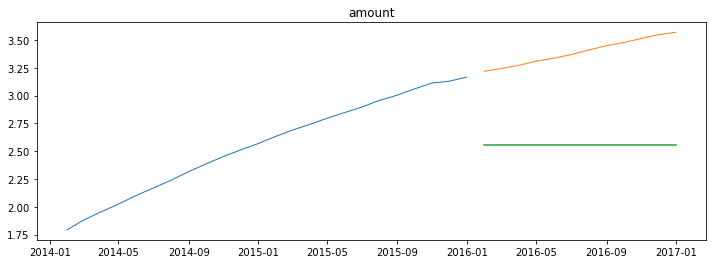

In [203]:
plot_and_eval('amount')

## Takeaways
* Based on the graph alone we can tell this method will be a bad choice to model on. Let's evalute the RMSE...

## Evaluate

In [205]:
  eval_df = append_eval_df(model_type='simple_average', 
                             target_var = 'amount')

In [206]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,0.84179


# 2) Moving Average

## Make Predictions

In [207]:
# compute a one-month rolling average, 
# use the most recent/last one-month period value to predict forward. 

period = 1

amount = round(train_month['amount'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,amount
Month_Invoiced,
2016-01-31,3.17
2016-02-29,3.17
2016-03-31,3.17


### Plot actual vs predicted values

amount -- RMSE: 0


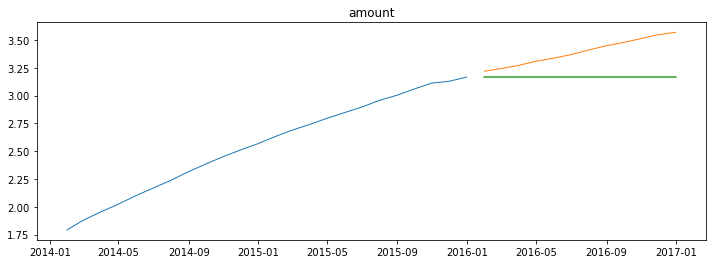

In [208]:
plot_and_eval('amount')

## Takeaways
* Based on the graph alone, using a period of one(1), the 'Moving Average' method seems to perform better than the 'Simple Average' method.
* Based on the autocorrelation graph above, it doesn't seem like using different periods will improve the predictions, but we will try anyways.

## Evaluate

In [209]:
eval_df = append_eval_df(model_type='1-month moving average', 
                             target_var = 'amount')

In [210]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,0.84179
1,1-month moving average,amount,0.24999


In [211]:
periods = [1, 2, 3, 4, 5, 6]

for p in periods:
    amount = round(train_month['amount'].rolling(p).mean().iloc[-1], 5)
    yhat_df = make_predictions()
    model_type = str(p) + '-month moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'amount'
                            )

In [212]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,0.84179
1,1-month moving average,amount,0.24999
2,1-month moving average,amount,0.25352
3,2-month moving average,amount,0.27058
4,3-month moving average,amount,0.28108
5,4-month moving average,amount,0.29881
6,5-month moving average,amount,0.31990
7,6-month moving average,amount,0.34142


# 3) Holt's Linear Trend Model

## Make Predictions

In [214]:
model = Holt(train_month['amount'], exponential = True)
model = model.fit(smoothing_level = 1, 
                  smoothing_slope = 1, 
                  optimized = False)
yhat_items = model.predict(start = validate_month.index[0], 
                           end = validate_month.index[-1])
yhat_df['amount'] = round(yhat_items, 5)

In [215]:
yhat_df

,amount
Month_Invoiced,
2016-01-31,3.20443
2016-02-29,3.24330
2016-03-31,3.28264
2016-04-30,3.32246
2016-05-31,3.36276
2016-06-30,3.40355
2016-07-31,3.44483
2016-08-31,3.48661
2016-09-30,3.52890


### Plot actual vs predicted

amount -- RMSE: 0


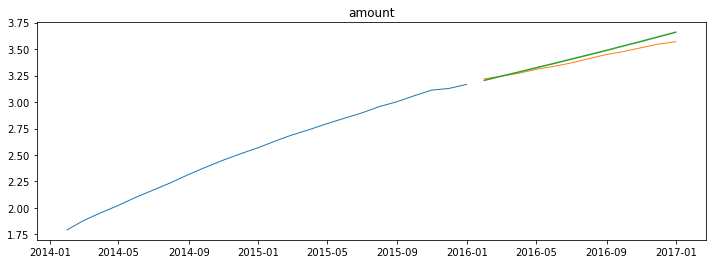

In [216]:
plot_and_eval('amount')

# Takeaways
* I'm sure this is the model we will move forward with. But, let's check the last one just to be sure.

## Evaluate

In [217]:
eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = 'amount')

In [218]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,0.84179
1,1-month moving average,amount,0.24999
2,1-month moving average,amount,0.25352
3,2-month moving average,amount,0.27058
4,3-month moving average,amount,0.28108
5,4-month moving average,amount,0.29881
6,5-month moving average,amount,0.31990
7,6-month moving average,amount,0.34142
8,Holts,amount,0.04507


# 4) Predict Based on Previous Cycle

In [222]:
df.index.min(), df.index.max()

(Timestamp('2014-01-31 00:00:00'), Timestamp('2017-12-31 00:00:00'))

### Re-split data

In [238]:
train = pd.DataFrame(df[:'2015'].resample('m').amount.mean())
validate = pd.DataFrame(df['2016'].resample('m').amount.mean())
test = pd.DataFrame(df['2017'].resample('m').amount.mean())

In [239]:
train

,amount
Month_Invoiced,
2014-01-31,1.792500
2014-02-28,1.878283
2014-03-31,1.953926
2014-04-30,2.022099
2014-05-31,2.099527
2014-06-30,2.166982
2014-07-31,2.237017
2014-08-31,2.314160
2014-09-30,2.383205


## Make Predictions

In [242]:
yhat_df = train['2015'] + train.diff(12).mean()

In [282]:
yhat_df

,amount
Month_Invoiced,
2015-01-31,3.353406
2015-02-28,3.408119
2015-03-31,3.459925
2015-04-30,3.514995
2015-05-31,3.566490
2015-06-30,3.616059
2015-07-31,3.676209
2015-08-31,3.722953
2015-09-30,3.778641


In [283]:
yhat_df.index = validate.index

len(yhat_df)

12

## Plot and Evaluate

amount -- RMSE: 0


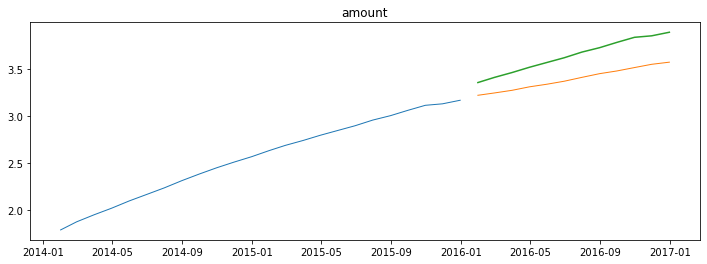

In [284]:
plot_and_eval('amount')
eval_df = append_eval_df(model_type = 'previous year', target_var = 'amount')

In [285]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,0.84179
1,1-month moving average,amount,0.24999
2,1-month moving average,amount,0.25352
3,2-month moving average,amount,0.27058
4,3-month moving average,amount,0.28108
5,4-month moving average,amount,0.29881
6,5-month moving average,amount,0.31990
7,6-month moving average,amount,0.34142
8,Holts,amount,0.04507
9,previous year,amount,0.25360


# Conclusion

### Which model performed the best?

#### Holt's Linear Trend Model performed the best. We will move forward using the Holt's model on our test dataset.

In [296]:
model = Holt(validate_month['amount'], exponential = True)
model = model.fit(smoothing_level = 1, 
                  smoothing_slope = 1, 
                  optimized = False)
yhat_items = model.predict(start = test_month.index[0], 
                           end = test_month.index[-1])
yhat_df.index = test_month.index
yhat_df['amount'] = round(yhat_items, 5)

In [297]:
yhat_df

,amount
Month_Invoiced,
2017-01-31,3.59224
2017-02-28,3.61520
2017-03-31,3.63831
2017-04-30,3.66157
2017-05-31,3.68498
2017-06-30,3.70853
2017-07-31,3.73224
2017-08-31,3.75610
2017-09-30,3.78011


In [298]:
rmse_amount = round(sqrt(mean_squared_error(test['amount'], yhat_df['amount'])), 5)

In [300]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train_month[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate_month[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test_month[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

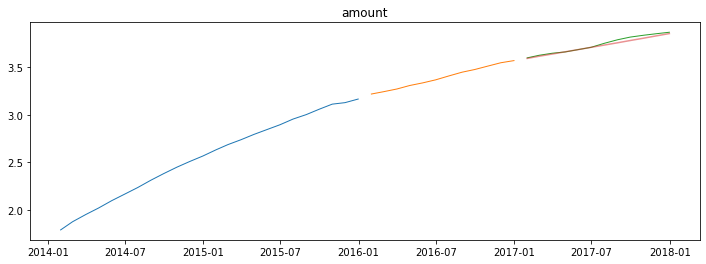

In [301]:
plot_and_eval('amount')

In [308]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(test_month[target_var], yhat_df[target_var])), 5)
    return rmse

def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [309]:
eval_df = append_eval_df(model_type = "Holt's_Test", target_var = 'amount')

In [310]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,0.84179
1,1-month moving average,amount,0.24999
2,1-month moving average,amount,0.25352
3,2-month moving average,amount,0.27058
4,3-month moving average,amount,0.28108
5,4-month moving average,amount,0.29881
6,5-month moving average,amount,0.31990
7,6-month moving average,amount,0.34142
8,Holts,amount,0.04507
9,previous year,amount,0.25360


# Takeaways
* I'm going to say my model is pretty accurate and I feel confident moving forward with it.